# **Introduction**
This workbook attempts to construct a Convlutional Neural Network to classify COVID-19 and Pneumonia using chest x-ray images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -R '/content/drive/MyDrive/Train' 'Train'
!cp -R '/content/drive/MyDrive/Test' 'Test'

# **Setup**
Import required packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, activations, losses, optimizers, metrics
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import pydotplus
from scipy import stats
from imblearn.over_sampling import SMOTE
# from keras.utils.vis_utils import model_to_dot
# keras.utils.vis_utils.pydotplus = pydotplus

# **Generate a Dataset**

In [ ]:
!pip install pillow --quiet

In [ ]:
import cv2
import os
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [ ]:

IMG_HEIGHT = 180
IMG_WIDTH = 180

def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path = os.path.join(img_folder, dir1,  file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255 
            if image.shape != (180, 180):
                print (image.shape)
            img_data_array.append(image)
            class_name.append(dir1)
    
    return np.array(img_data_array), np.array(class_name)

  
PIL_img_data, class_name = create_dataset(r'./Train')

In [ ]:
target_dict = {
    k: v for v, k in enumerate(np.unique(class_name))
}

target_val = np.array(
    [
        target_dict[class_name[i]] for i in range(len(class_name))
    ]
)

In [ ]:
PIL_img_data = PIL_img_data.reshape(-1, 180, 180, 1)
PIL_img_data.shape

(3010, 180, 180, 1)

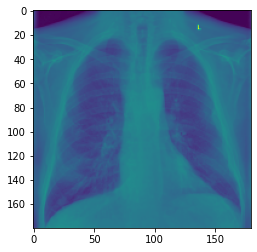

In [ ]:
plt.imshow(PIL_img_data[0].reshape(180,180))
plt.show()

In [ ]:
image_size = (180, 180)
batch_size = 1024
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    # r"C:\Users\hp\Desktop\Sem 6\Minor 2\project\Data\train",
    r"./Train",
    validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=image_size, 
    batch_size=batch_size
)


Found 3010 files belonging to 3 classes.
Using 2709 files for training.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA']


# **Visualize the Data**
First 9 Images from the dataset

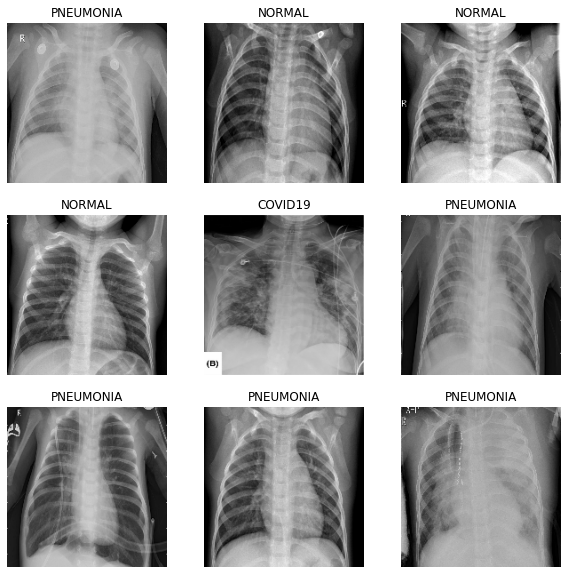

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Image Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

- The images after random augmentation

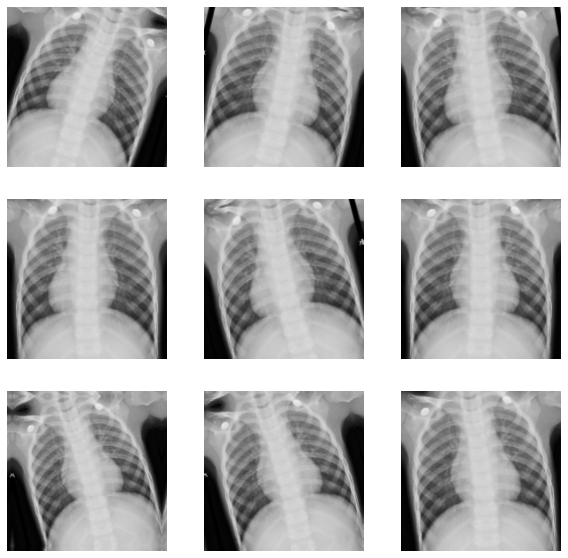

In [ ]:
train_ds = train_ds.shuffle(buffer_size=10)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Configure the dataset for performance**

In [ ]:
train_ds = train_ds.prefetch(buffer_size=batch_size)

# **Build Model**

In [ ]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = activations.relu(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = activations.relu(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = activations.relu(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = activations.relu(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = activations.relu(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(3)(x)
    outputs = activations.softmax(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=(IMG_HEIGHT, IMG_WIDTH) + (1,), num_classes=3)

tf.keras.utils.plot_model(model, show_shapes=True)
plt.show()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, None)    0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 32)        832       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        51264     
                                                             

In [ ]:
# checkpoint_filepath = '/content/content'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights = True)

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# **Train the Model**

In [ ]:
epochs = 50

model.compile(
    optimizer= optimizers.Adam(),
    loss = losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

history = model.fit(
    x=PIL_img_data, 
    y=target_val, 
    epochs = epochs,
    batch_size=1024
)

Epoch 1/50
3/3 [==============================] - 30s 5s/step - loss: 1.4176 - accuracy: 0.4189
Epoch 2/50
3/3 [==============================] - 2s 490ms/step - loss: 1.0634 - accuracy: 0.4259
Epoch 3/50
3/3 [==============================] - 1s 490ms/step - loss: 1.0855 - accuracy: 0.4266
Epoch 4/50
3/3 [==============================] - 1s 495ms/step - loss: 1.0778 - accuracy: 0.4266
Epoch 5/50
3/3 [==============================] - 1s 491ms/step - loss: 1.0649 - accuracy: 0.4266
Epoch 6/50
3/3 [==============================] - 1s 482ms/step - loss: 1.0526 - accuracy: 0.4266
Epoch 7/50
3/3 [==============================] - 1s 484ms/step - loss: 1.0390 - accuracy: 0.4266
Epoch 8/50
3/3 [==============================] - 1s 488ms/step - loss: 1.0262 - accuracy: 0.4286
Epoch 9/50
3/3 [==============================] - 1s 495ms/step - loss: 1.0150 - accuracy: 0.4355
Epoch 10/50
3/3 [==============================] - 1s 492ms/step - loss: 1.0122 - accuracy: 0.4113
Epoch 11/50
3/3 [====

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Test",
    validation_split=0.1,
    color_mode='grayscale',
    subset="validation",
    seed=1337,
    image_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=512,
)


Found 1288 files belonging to 3 classes.
Using 128 files for validation.


In [ ]:
test_ds_images, test_ds_class = create_dataset(r'./Test')

target_dict = {
    k: v for v, k in enumerate(np.unique(test_ds_class))
}

test_val = np.array(
    [
        target_dict[test_ds_class[i]] for i in range(len(test_ds_class))
    ]
)

In [ ]:
test_ds_images = test_ds_images.reshape(-1, 180, 180, 1)
test_ds_images.shape

(1288, 180, 180, 1)

In [ ]:
test_ds = test_ds.prefetch(buffer_size=32)

In [ ]:
y_pred = model.predict(test_ds_images)

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(test_val.reshape(-1, 1))

Y = tf.one_hot(tf.argmax(y_pred, axis=1), y_pred.shape[1])

print(classification_report (onehot_encoded, Y))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       116
           1       0.78      0.99      0.87       317
           2       0.99      0.90      0.94       855

   micro avg       0.92      0.92      0.92      1288
   macro avg       0.92      0.94      0.92      1288
weighted avg       0.94      0.92      0.93      1288
 samples avg       0.92      0.92      0.92      1288



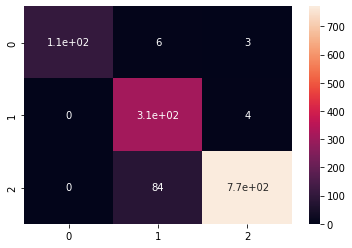

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

cnf_matrix = confusion_matrix (np.argmax (onehot_encoded, axis=1), np.argmax (Y, axis=1))
heatmap (cnf_matrix, annot=True)
plt.show ()

In [ ]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

print (f'Specificity: {TNR}\nSensitivity: {TPR}')

Specificity: [1.         0.90731205 0.98383372]
Sensitivity: [0.92241379 0.9873817  0.90175439]


In [ ]:
model.save("/content/drive/MyDrive/covidxray.h5")

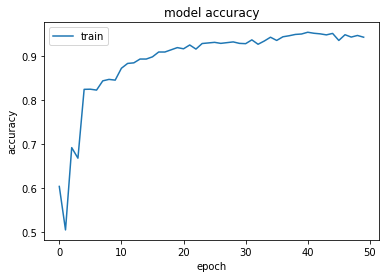

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

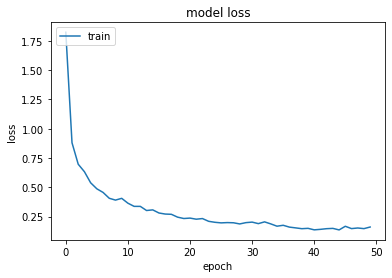

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [ ]:
model= tf.keras.models.load_model("/content/drive/MyDrive/covidxray.h5")

# **Testing the Model**

In [ ]:
image_path1 = "/content/Test/COVID19/COVID19(466).jpg"
image_path2 = "/content/Test/NORMAL/NORMAL(1268).jpg"
image_path3 = "/content/Test/PNEUMONIA/PNEUMONIA(3423).jpg"
merged_path = [image_path1, image_path2, image_path3]
img_array = []
class_names = ['Covid', 'Normal', 'Pneumonia']

for img_path in merged_path:
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255 
    img_array.append(image)

    
    
img_array = np.array(img_array)
img_array = img_array.reshape(-1, 180, 180, 1)

predictions = model.predict(img_array)

for i in range (3):
    score = tf.nn.softmax(predictions[i])
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

This image most likely belongs to Covid with a 55.67 percent confidence.
This image most likely belongs to Normal with a 57.23 percent confidence.
This image most likely belongs to Pneumonia with a 57.35 percent confidence.
